In [10]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from detrend_func import detrend_func
from window_func import main as window_func

import dask
from distributed import Client, LocalCluster
import dask.array as da

import xarray as xr

In [2]:
# create a Dask Distributed cluster with one processor and as many
# threads as cores
cluster = LocalCluster(n_workers=1)
client = Client(cluster)

### Define constants to be used

In [3]:
dx = 5000. # meters
dy = 5000. # meters
dt = 1 # in days
H = [350.0, 750.0, 2900.0]  # meters
Htot = H[0] + H[1] + H[2]
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
g = [.015, .0075]

In [4]:
tile_size = 100

#### RUN ONCE ONLY

#### ran on raijin with 32gb node. Takes about 70-80s per iteration

"""
indatadir = '/g/data1/v45/pm2987/Spunup'
outdatadir = '/g/data1/v45/jm0634/paige/Spunup_T'

for ncfile in ncfiles:
    outncfile = ncfile.replace(indatadir, outdatadir)
    outdir = os.path.dirname(outncfile)
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    if os.path.exists(outncfile):
        continue
        
    ds = xr.open_dataset(ncfile)\
           .isel(time=slice(None,-1)) # remove last time value since it repeated at the
                                      # start of each output file
    ds = ds.transpose('zi', 'z', 'yp', 'xp', 'time')
    
    encoding = { 'p'    : {'chunksizes': [1, 100, 100, 365]},
                 'q'    : {'chunksizes': [1, 100, 100, 365]},
                 'h'    : {'chunksizes': [1, 100, 100, 365]},
                 'taux' : {'chunksizes': [100, 100, 365]},
                 'tauy' : {'chunksizes': [100, 100, 365]},              
                 'e'    : {'chunksizes': [100, 100, 365]},
               }
    for v in encoding:
        encoding[v].update({'complevel': 0, 
                            'contiguous': False,
                            'dtype': np.dtype('float32'),
                            'source': ncfile,
                            'zlib': False})
    
    ds.to_netcdf(outncfile, engine='netcdf4', format='NETCDF4', encoding=encoding)
    del ds
"""

In [5]:
datadir = '/g/data1/v45/jm0634/paige/Spunup_T'

#ncfiles = sorted(glob(os.path.join(datadir, 'output*/ocpo.nc'))) # for all files
ncfiles = sorted(glob(os.path.join(datadir, 'output013/ocpo.nc')))

Construct a DataArray of all output files (takes a few seconds)

In [6]:
chunks = {'xp': tile_size, 'yp': tile_size, 
          'time':365, 'z':1, 'zi':1}

datasets = [xr.open_dataset(fn, 
                            chunks=chunks)
            for fn in ncfiles]

dsx = xr.concat(datasets, dim='time', coords='all')

### KE

$$
\frac{H_1}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_1}^* 
\widehat{J(\nabla_H^2 p_1,p_1)}\right]
+ \frac{H_2}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_2}^* 
\widehat{J(\nabla_H^2 p_2, p_2)}\right]
+\frac{H_3}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{J(\nabla_H^2 p_3, p_3)}\right]
$$

In [9]:
def calc_KE(dsx, tile_index, z=0):
    
    # select variables
    p = dsx.p.isel(z=z)

        
    ix, iy = tile_index
    p = p.isel(yp=slice(iy*tile_size-3, (iy+1)*tile_size+3),
               xp=slice(ix*tile_size-3, (ix+1)*tile_size+3))
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    p = p.rechunk(chunks={0: tile_size + 6, 1:tile_size+6})
        
    def Jacobian(p):
        # stencil
        p_cc = p
        p_ac = np.roll(p_cc,  2, axis=0)
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_ec = np.roll(p_cc, -2, axis=0)
    
        p_ca = np.roll(p_cc, -2, axis=1)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        p_ce = np.roll(p_cc,  2, axis=1)
    
        p_bb = np.roll(p_bc, -1, axis=1)
        p_bd = np.roll(p_bc,  1, axis=1)
        p_db = np.roll(p_dc, -1, axis=1)
        p_dd = np.roll(p_dc,  1, axis=1) 
        
        p_x = p_cd - p_cb
        p_y = p_bc - p_dc
        delp_x = (p_ce + p_bd + p_dd - 4*p_cd) - (p_ca + p_bb + p_db - 4*p_cb)
        delp_y = (p_bb + p_ac + p_bd - 4*p_bc) - (p_db + p_ec + p_dd - 4*p_dc)
    
        J = delp_x*p_y - delp_y*p_x
        return J

    J = p.map_blocks(Jacobian)
    J = J[3:tile_size+3, 3:tile_size+3, :]

    # TODO: handle boundary
        
    dx = xp[1] - xp[0]
    dy = yp[1] - yp[1]
    # TODO: divide by gridsize^4 to get derivative
    J = 1/(dx**4)*J
    
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    Jhat = da.fft.rfft(J, axis=2)
    Jhat = Jhat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})

    p = p[3:tile_size+3, 3:tile_size+3, :]
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    phat = da.fft.rfft(p, axis=2)
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    KE = H[z] / (f0**3 * Htot) *(phat.conj()*Jhat).real

    KE = da.sum(KE, axis=(0,1))
    
    KE = KE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    KE = xr.DataArray(KE, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return KE

### PE


$$
\frac{1}{f_0 H_{tot}} \frac{1}{g_1'}  \mathrm{Re}  \left[ \widehat{(p_2 - p_1)}^* \widehat{J( p_1,p_2)} \right]
+ \frac{1}{f_0 H_{tot}} \frac{1}{g_2'}  \mathrm{Re}  \left[ \widehat{(p_3 - p_2)}^* \widehat{J( p_2,p_3)} \right]
$$


In [117]:
def calc_PE(dsx, tile_index, z=0):
    
    # select variables
    p1 = dsx.p.isel(z=z)
    p2 = dsx.p.isel(z=z+1)
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    p2 = p2.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))

    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data 
    
    if ix==0:
        p1 = da.concatenate([p1[:,slice(0,1),:], p1], axis=1)
        p2 = da.concatenate([p2[:,slice(0,1),:], p2], axis=1)
    if iy==0:
        p1 = da.concatenate([p1[slice(0,1),:,:], p1], axis=0)
        p2 = da.concatenate([p2[slice(0,1),:,:], p2], axis=0)
    if ix==9:
        p1 = da.concatenate([p1, p1[:,slice(-1,None),:]], axis=1)
        p2 = da.concatenate([p2, p2[:,slice(-1,None),:]], axis=1)
    if iy==9:
        p1 = da.concatenate([p1, p1[slice(-1,None),:,:]], axis=0)
        p2 = da.concatenate([p2, p2[slice(-1,None),:,:]], axis=0)
        
    ny, nx, nt = p1.shape
    p1 = p1.rechunk(chunks={0: ny, 1: nx})
    p2 = p2.rechunk(chunks={0: ny, 1: nx})

    def Derivative(p, axis):
        p_right = np.roll(p, 1, axis=axis)
        p_left = np.roll(p, -1, axis=axis)
        dp = p_right - p_left
        return dp
        
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    p1x = p1.map_blocks(Derivative_x)
    p1y = p1.map_blocks(Derivative_y)
    p2x = p2.map_blocks(Derivative_x)
    p2y = p2.map_blocks(Derivative_y)

    J = p1x*p2y - p1y*p2x
    
    J = J[1:tile_size+1, 1:tile_size+1, :]
    
    ds = da.ones(J.shape, chunks=J.chunks)*4*dx
    if ix==0:
        ds = da.concatenate( [ ds[:,slice(0,1),:]/4, ds[:,1:,:] ], axis = 1)
    if iy==0:
        ds = da.concatenate( [ ds[slice(0,1),:,:]/4, ds[1:,:,:] ], axis = 0)
    if ix==9:
        ds = da.concatenate( [ ds[:,slice(-1,None),:]/4, ds[:,:-1,:] ], axis = 1)
    if iy==9:
        ds = da.concatenate( [ ds[slice(-1, None),:,:]/4, ds[:-1,:,:] ], axis = 0)
        
    # divide needed for derivatives
    J = J / ds
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    #Jhat = da.fft.rfft(J, axis=2)
    
    pdiff = p2 - p1
    pdiff = pdiff[1:tile_size+1, 1:tile_size+1, :]
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 
                                  1: tile_size/10, 
                                  2: 365*100})
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    #pdiffhat = da.fft.rfft(pdiff, axis=2)
    Jhat = Jhat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    pdiffhat = pdiffhat.rechunk(chunks={0: tile_size, 
                                        1: tile_size, 
                                        2: 365})
    
    PE = 1 / (f0 * Htot)*(1/g[0])*(pdiffhat.conj()*Jhat).real

    PE = da.sum(PE, axis=(0,1))
    
    PE = PE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    PE = xr.DataArray(PE,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    return PE

calc_PE(dsx, (9,9))

Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time


<xarray.DataArray (freq: 183)>
array([  8.738687e-06,  -3.440605e-04,  -3.097994e-04,   1.724781e-04,
        -5.998562e-04,  -2.134669e-04,  -3.229145e-04,  -3.631788e-04,
        -2.134326e-04,  -8.273149e-05,  -5.780118e-05,  -3.748750e-05,
        -5.211939e-05,  -4.714900e-05,  -5.391379e-05,  -6.555213e-05,
        -3.756910e-05,  -3.068712e-07,  -2.030044e-05,  -3.509006e-05,
        -3.490827e-06,  -1.532051e-05,  -3.755303e-06,   1.013803e-06,
        -2.253907e-05,  -7.273179e-06,  -6.319849e-06,  -4.978240e-06,
        -1.118013e-05,  -6.397172e-06,  -8.945927e-06,  -1.910939e-06,
         2.043521e-06,  -1.517608e-06,  -6.883548e-06,  -2.865439e-06,
        -4.056474e-06,  -2.455556e-06,  -2.264821e-06,  -2.008641e-06,
        -2.733109e-06,  -5.851412e-07,  -1.838109e-06,  -1.342782e-06,
        -1.969213e-06,  -9.275928e-07,  -9.004225e-07,   1.346842e-07,
        -5.050894e-07,  -4.902990e-07,  -7.579643e-07,  -2.085560e-07,
        -7.865286e-08,   4.859428e-07,  -7.373

## Buoyancy

$$
\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{(p_2 - p_1)}^* \widehat{e_1} \right]
$$


In [116]:
def calc_buoyancy(dsx, tile_index):
    # select variables
    p1 = dsx.p.isel(z=0)
    p2 = dsx.p.isel(z=1)
    e = dsx.e
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    p2 = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    e = e.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    e = e.data
    
    pdiff = p2 - p1
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)

        return varhat

    
    e = e.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    print (e)
    # Execute fft function above
    ehat = e.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    e = e.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    pdiff = pdiff.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    buoyancy = (1 / Htot)*(pdiffhat.conj()*ehat).real

    buoyancy = da.sum(buoyancy, axis=(0,1))
    
    buoyancy = buoyancy.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    buoyancy = xr.DataArray(buoyancy,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return buoyancy

In [ ]:
def calc_windstress(dsx, tile_index):
    # select variables
    p1 = dsx.p.isel(z=0)
    wek = dsx.e
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    p2 = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    e = e.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    e = e.data
    
    pdiff = p2 - p1
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)

        return varhat

    
    e = e.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 1: tile_size/10

In [13]:
%%time
buoyancy = calc_buoyancy(dsx,(2,3))

dask.array<rechunk-merge, shape=(100, 100, 365), dtype=float32, chunksize=(10, 10, 365)>
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
CPU times: user 1.65 s, sys: 53 ms, total: 1.7 s
Wall time: 3.42 s


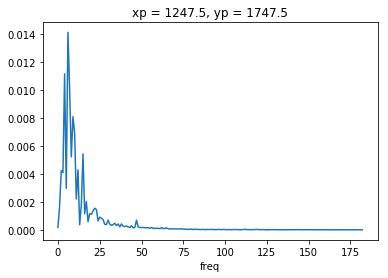

In [14]:
buoyancy.plot()

In [118]:
%%time
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range((961+tile_size+1)//(tile_size)) 
xi = range((961+tile_size+1)//(tile_size))

tile_indexes = list(product(*[yi, xi]))

KE_sum = 0
results = []
buoyancy_sum = 0
PE_sum = 0
for tile_index in tile_indexes[:]:
    #KE1 = calc_KE(dsx, tile_index, 0)
    #KE2 = calc_KE(dsx, tile_index, 1)
    #KE3 = calc_KE(dsx, tile_index, 2)
    #KE = KE1+KE2+KE3
    
    PE1 = calc_PE(dsx, tile_index, 0)
    #PE2 = calc_PE(dsx, tile_index, 1)
    
    #PE = PE1 + PE2
    PE_sum += PE1
    #buoyancy = calc_buoyancy(dsx, tile_index)
    
    #buoyancy_sum = buoyancy_sum + buoyancy
    
    # Want to sum each buoyancy term, and divide by the total number of spatial points
    #results.append(buoyancy)
    #results.sum(buoyancy)
    
    #results.append(KE)
    
#buoyancy_avg = buoyancy_sum/(961*961)

Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detren

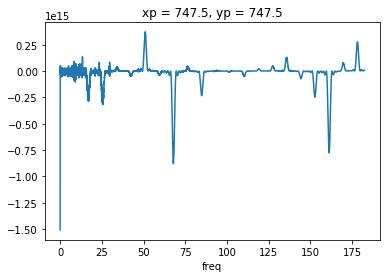

In [68]:
KE1.plot()

In [10]:
buoyancy_avg.shape

(183,)

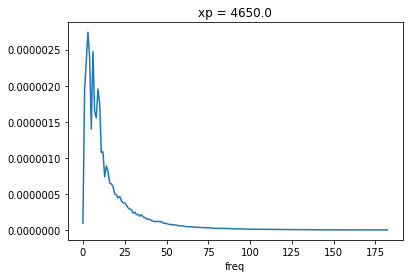

In [115]:
buoyancy_sum.plot()

In [104]:
# Define ktiso for plotting
ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.figure()
plt.plot(buoyancy_avg*ktiso)
plt.xscale('log')

NameError: name 'buoyancy_avg' is not defined

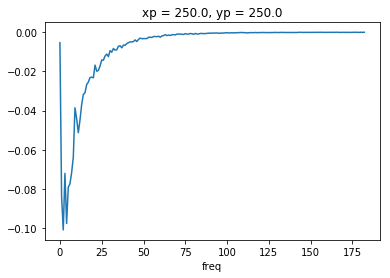

In [119]:
PE_sum.plot()

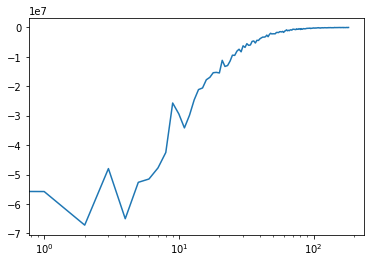

In [106]:
plt.figure()
plt.plot(PE_sum)
plt.xscale('log')